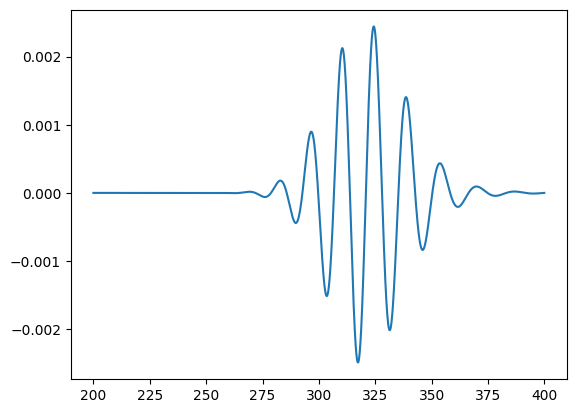

In [34]:
from Class import SchwarzschildPerturbation, gaussian_initial_profile
import matplotlib.pyplot as plt
import numpy as np

M = 1
l = 2
parity = 'axial'
rstar_min = -400
rstar_max = 700
dx = 0.1

axial_sim = SchwarzschildPerturbation(M, l, parity, rstar_min, rstar_max, dx = 0.1)
Psi0 = gaussian_initial_profile(axial_sim.rstar, 110*M, 15*M, 0.5)
sim = axial_sim.solve(Psi0, 8000)
Psi = sim.Psi
index = np.argmin(np.abs(axial_sim.rstar - 200*M))

plt.figure()
plt.plot(axial_sim.times[4000:], Psi[:, index][4000:])
plt.show()


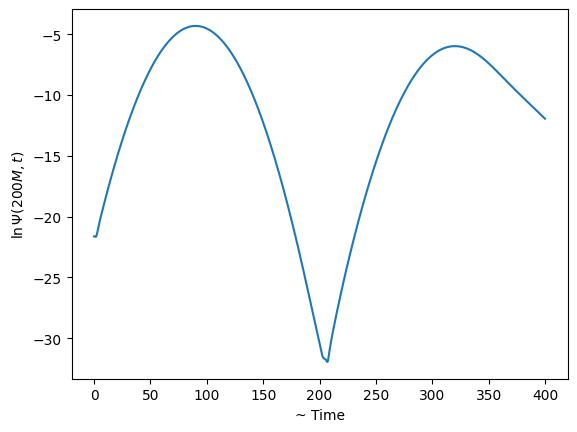

In [38]:
plt.figure()
plt.plot(axial_sim.times, np.log(np.abs(Psi[:,index])))
plt.ylabel(r"$\ln{\Psi \left(200M, t\right)}$")
plt.xlabel(r"~ Time")
plt.show()